In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import Dropout, Activation, LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [6]:
df = pd.read_csv('../datasets/kraken_data.csv')

In [7]:
df.head()

,uuid,exchange,ask_price,ask_whole_lot_volume,ask_lot_volume,bid_price,bid_whole_lot_volume,bid_lot_volume,close_price,close_volume,volume_avg_today,volume_avg_24h,trades_today,trades_24h,low_today,low_24h,high_today,high_24h,opening_price,ts
0,9831925d-f9b1-4fde-9d40-34c5dc222a91,kraken,0.000804,289,289,0.000802,150,150,0.000805,150,94508.35523,176635.0497,1087,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
1,63644912-c186-4a7c-a0fd-739520c879b6,kraken,0.000804,334,334,0.000802,150,150,0.000805,150,103094.91810,176635.0497,1196,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
2,8150086e-98d8-4dd3-91fa-111923a6f78c,kraken,0.000804,289,289,0.000802,150,150,0.000805,150,103094.95470,176635.0497,1198,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
3,6df11107-1be2-4e31-97a6-d20e80431b14,kraken,0.000804,134,134,0.000802,150,150,0.000805,150,103249.37390,176635.0497,1199,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487
4,2d2358d9-dec6-49be-b309-33db96b75eaa,kraken,0.000804,134,134,0.000802,150,150,0.000805,150,103279.59390,176635.0497,1200,2278,0.000787,0.000787,0.000855,0.000855,0.000802,25569.50487


In [9]:
drop_cols = ['uuid', 
             'exchange', 
             'volume_avg_today', 
             'volume_avg_24h', 
             'trades_today', 
             'trades_24h', 
             'low_today', 
             'low_24h', 
             'high_today', 
             'high_24h', 
             'opening_price']

In [11]:
df_subset = df.drop(drop_cols, 1)

In [12]:
df_subset.head()

,ask_price,ask_whole_lot_volume,ask_lot_volume,bid_price,bid_whole_lot_volume,bid_lot_volume,close_price,close_volume,ts
0,0.000804,289,289,0.000802,150,150,0.000805,150,25569.50487
1,0.000804,334,334,0.000802,150,150,0.000805,150,25569.50487
2,0.000804,289,289,0.000802,150,150,0.000805,150,25569.50487
3,0.000804,134,134,0.000802,150,150,0.000805,150,25569.50487
4,0.000804,134,134,0.000802,150,150,0.000805,150,25569.50487


In [14]:
# We want 80% of the data to be used for training, and 20% for testing
n_train_rows = int(df_subset.shape[0]*.8)-1

In [16]:
train = df_subset.iloc[:n_train_rows, :]
test = df_subset.iloc[n_train_rows:, :]

In [17]:
print(train.shape)
print(test.shape)

(26638, 9)
(6661, 9)


In [19]:
(train.shape[0] + test.shape[0]) == len(df_subset)

True

In [20]:
# Normalise features
sc = MinMaxScaler(feature_range = (0, 1))

training_set_scaled = sc.fit_transform(train.values)
test_set_scaled = sc.fit_transform(test.values)

In [21]:
steps = 50

In [23]:
# Prepare the training data
x_train = []
y_train = []

for i in range(steps, training_set_scaled.shape[0] - steps):
    x_train.append(training_set_scaled[i-steps:i, :])
    y_train.append(training_set_scaled[i, :])

In [24]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [25]:
print(x_train.shape)

(26538, 50, 9)


In [29]:
# Prepare the test data
x_test = []
y_test = []

for i in range(steps, test_set_scaled.shape[0]):
    x_test.append(test_set_scaled[i-steps:i, :])
    y_test.append(test_set_scaled[i, :])

In [30]:
x_test, y_test = np.array(x_test), np.array(y_test)

In [31]:
print(x_test.shape)

(6611, 50, 9)


In [35]:
#model = load_model('bitcoin_forecast_model_10_epochs.h5')

In [41]:
model = Sequential()
model.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1],9)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=9))

model.compile(loss="mse", optimizer="adam")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 50)            12000     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)               

In [42]:
epochs = 10

In [43]:
model.fit(x_train, y_train, batch_size = 32, epochs = epochs)

Epoch 1/10
830/830 [==============================] - 40s 42ms/step - loss: 0.0403
Epoch 2/10
830/830 [==============================] - 36s 43ms/step - loss: 0.0258
Epoch 3/10
830/830 [==============================] - 37s 44ms/step - loss: 0.0234
Epoch 4/10
830/830 [==============================] - 36s 43ms/step - loss: 0.0226
Epoch 5/10
830/830 [==============================] - 36s 43ms/step - loss: 0.0220
Epoch 6/10
830/830 [==============================] - 36s 43ms/step - loss: 0.0218
Epoch 7/10
830/830 [==============================] - 36s 43ms/step - loss: 0.0220
Epoch 8/10
830/830 [==============================] - 36s 43ms/step - loss: 0.0219
Epoch 9/10
830/830 [==============================] - 36s 43ms/step - loss: 0.0215
Epoch 10/10
830/830 [==============================] - 36s 43ms/step - loss: 0.0215


In [ ]:
#model.save("bitcoin_forecast_model_"+str(epochs)+"_epochs.h5")
#print("Saved model to disk")

In [44]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(x_test, y_test, batch_size=32)
print('test loss, test acc:', results)


# Evaluate on test data
207/207 [==============================] - 5s 17ms/step - loss: 72701056.0000
test loss, test acc: 72701056.0


In [45]:
# Predict values from test data trained using training data
y_hat = model.predict(x_test)
y_hat = sc.inverse_transform(y_hat)

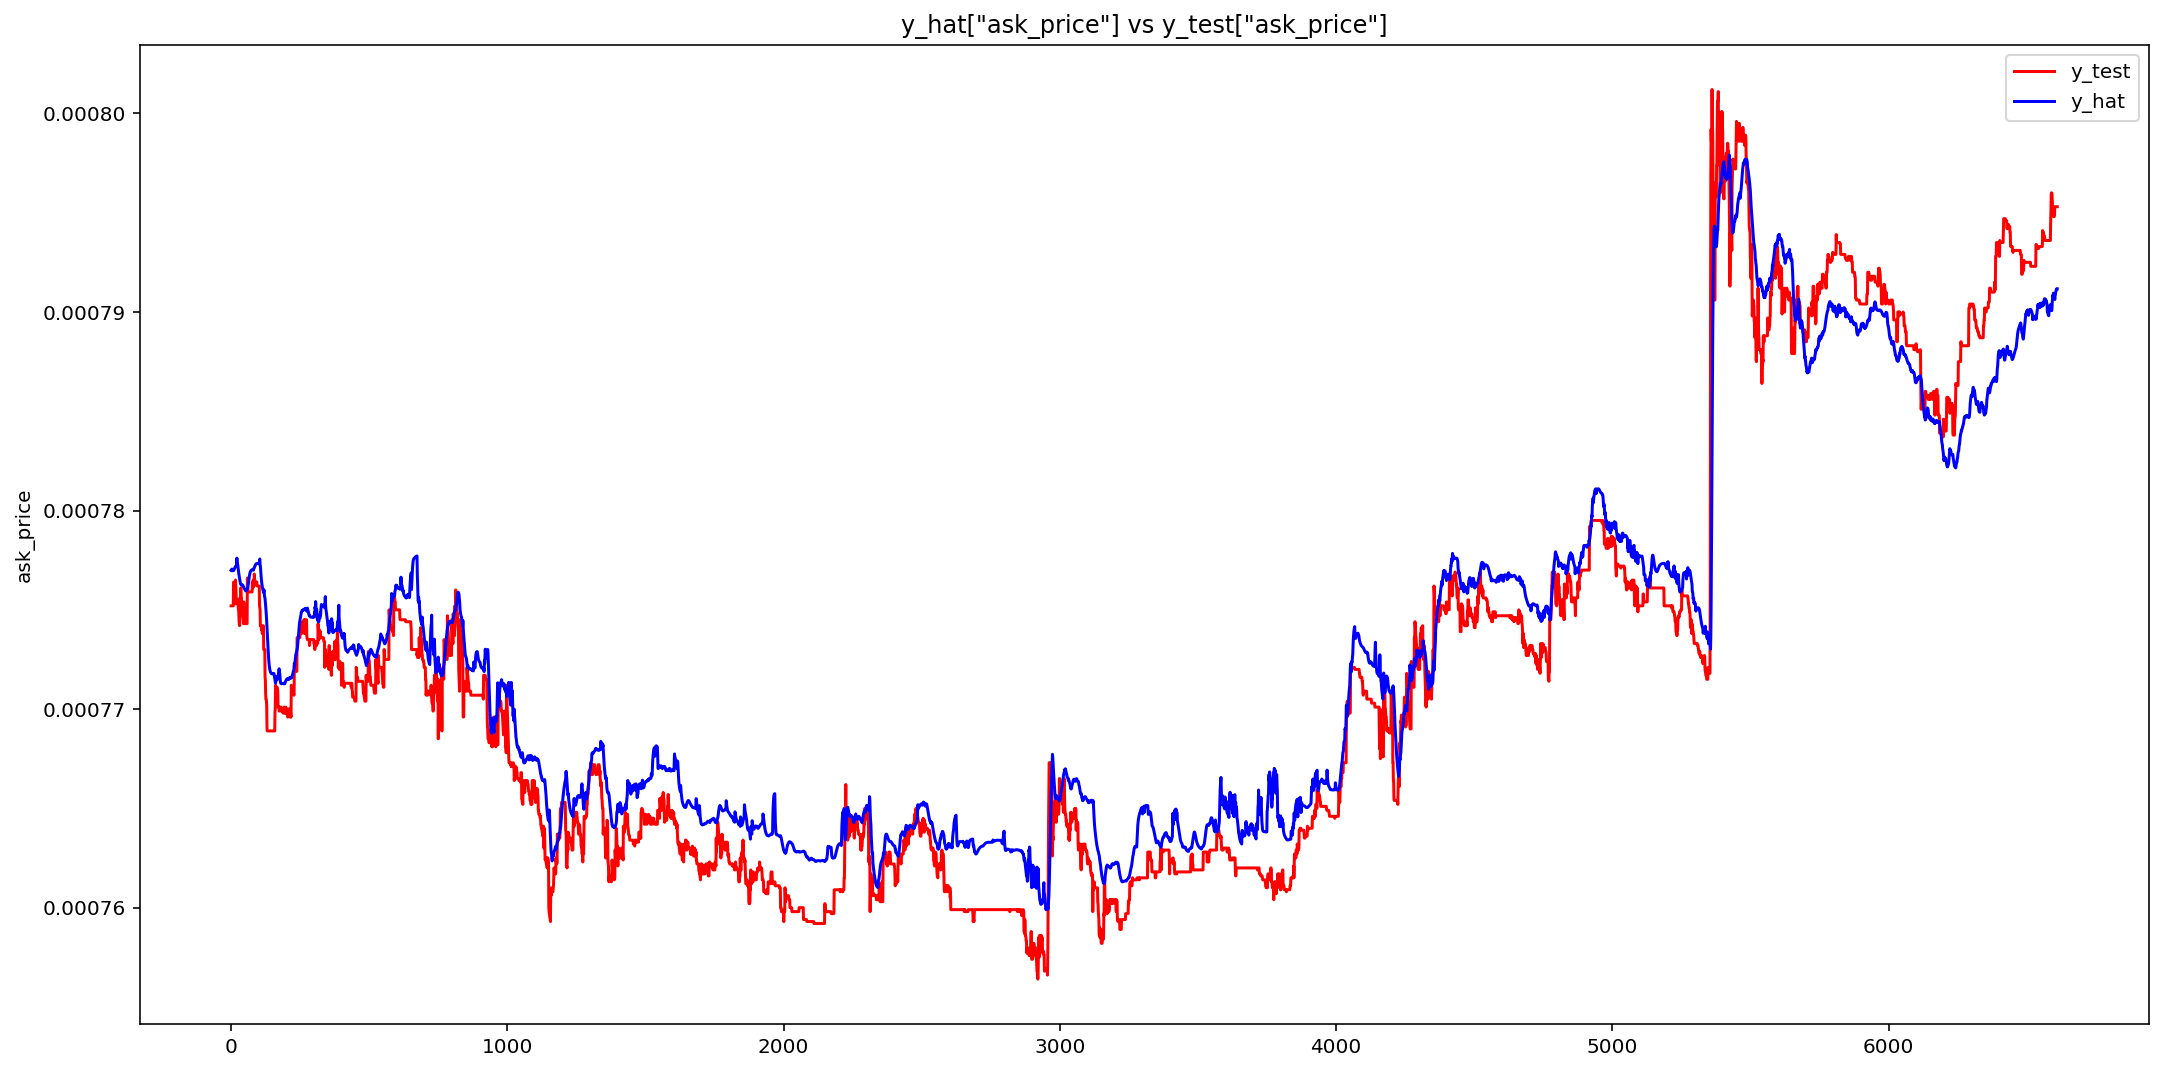

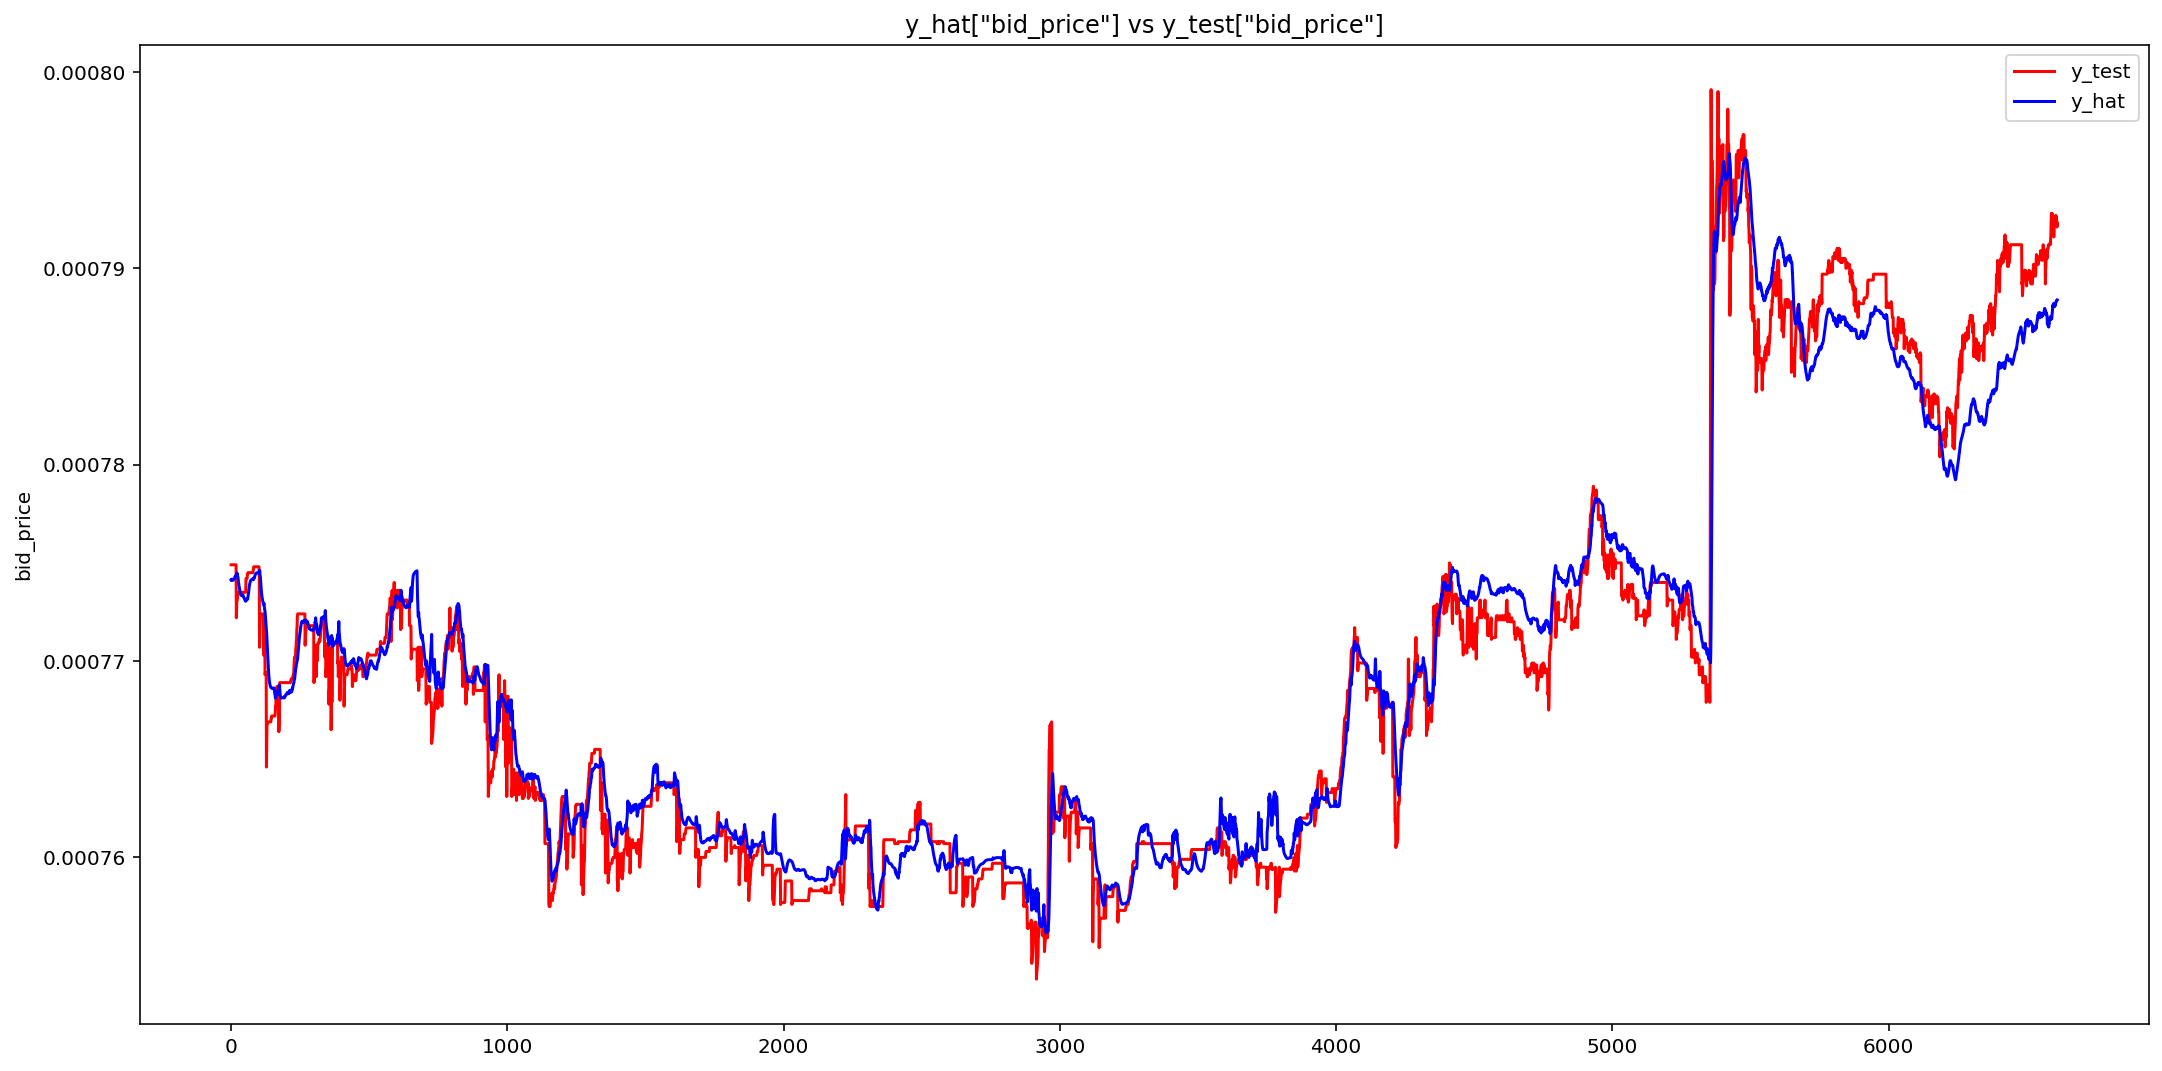

In [46]:
y_test = test[steps:].reset_index(drop=True)

# Visualise the ask_price predictions
plt.figure(figsize = (18,9))
plt.plot(y_test['ask_price'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,0], color = 'blue', label = 'y_hat')
plt.title('y_hat["ask_price"] vs y_test["ask_price"]')
plt.ylabel('ask_price')
plt.legend()
plt.show()

# Visualise the bid_price predictions
plt.figure(figsize = (18,9))
plt.plot(y_test['bid_price'], color = 'red', label = 'y_test')
plt.plot(y_hat[:,3], color = 'blue', label = 'y_hat')
plt.title('y_hat["bid_price"] vs y_test["bid_price"]')
plt.ylabel('bid_price')
plt.legend()
plt.show()